# Training a Classifier for CIFAR-10 with ResNet18

This tutorial introduces how to use `pytagi` to train a model that is able to classify the CIFAR-10 images using a ResNet18 architecture. Run it now in [Google Colab](https://colab.research.google.com/drive/1-yRdLkK05W7ISViBsoZdnteElhjAgCEH?usp=sharing).

## Load and normalize CIFAR-10

In this tutorial we will make use of `torch` and `torchvision` to load and normalize the CIFAR-10 images. We define the batch size as well for the data processing.

In [ ]:
# Uncomment the following lines to install the required packages if not already installed
!pip install pytagi
!pip install numpy
!pip install tqdm

import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

We create a custom collate function

In [ ]:
def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images to shape (B*C*H*W,)
    batch_images = batch_images.reshape(-1)

    # Convert to numpy arrays
    batch_images = batch_images.numpy()
    batch_labels = batch_labels.numpy()

    return batch_images, batch_labels

In [ ]:
"""Load and transform CIFAR10 training and test datasets."""
# Constants for dataset normalization
NORMALIZATION_MEAN = [0.4914, 0.4822, 0.4465]
NORMALIZATION_STD = [0.2470, 0.2435, 0.2616]

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToImage(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(
            mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(
            mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD
        ),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data/cifar",
    train=True,
    download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data/cifar",
    train=False,
    download=True,
    transform=transform_test,
)


Files already downloaded and verified
Files already downloaded and verified


We can see some of the MNIST images :)

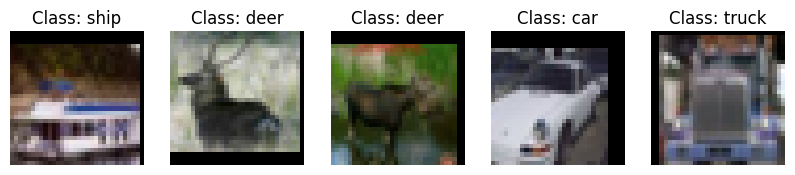

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Create DataLoaders for the training and test sets
batch_size = 64 # Define a batch size
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Get a batch from the training data loader
images, labels = next(iter(train_loader))

# Reshape the images back to 3x32x32 for plotting and transpose to 32x32x3 for matplotlib
images = images.permute(0, 2, 3, 1)

# Display a few images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    # Denormalize the image for display
    img = images[i].numpy() * np.array(NORMALIZATION_STD) + np.array(NORMALIZATION_MEAN)
    img = np.clip(img, 0, 1)  # Clip values to be within [0, 1] after denormalization
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {classes[labels[i]]}")
    axes[i].axis('off')
plt.show()

## Define a ResNet18

Next we define our residual network of 18 layers. Because the images are in color, we specify three channels in the entrance as well as the dimension of the images, which will be scaled to 32x32.

In [ ]:
from pytagi.nn import (
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    LayerBlock,
    Linear,
    MixtureReLU,
    ResNetBlock,
    Sequential,
)

def make_layer_block(
    in_c: int,
    out_c: int,
    stride: int = 1,
    padding_type: int = 1,
    gain_weight: float = 1,
    gain_bias: float = 1,
):
    """Create a layer block for resnet 18"""

    return LayerBlock(
        Conv2d(
            in_c,
            out_c,
            3,
            bias=False,
            stride=stride,
            padding=1,
            padding_type=padding_type,
            gain_weight=gain_weight,
            gain_bias=gain_bias,
        ),
        MixtureReLU(),
        BatchNorm2d(out_c),
        Conv2d(
            out_c,
            out_c,
            3,
            bias=False,
            padding=1,
            gain_weight=gain_weight,
            gain_bias=gain_bias,
        ),
        MixtureReLU(),
        BatchNorm2d(out_c),
    )

def resnet18_cifar10(
    gain_w: float = 1, gain_b: float = 1
) -> Sequential:
    """Resnet18 architecture for cifar10"""
    # 32x32
    initial_layers = [
        Conv2d(
            3,
            64,
            3,
            bias=False,
            padding=1,
            in_width=32,
            in_height=32,
            gain_weight=gain_w,
        ),
        MixtureReLU(),
        BatchNorm2d(64),
    ]

    resnet_layers = [
        # 32x32
        ResNetBlock(make_layer_block(64, 64, gain_weight=gain_w)),
        ResNetBlock(make_layer_block(64, 64, gain_weight=gain_w)),
        # 16x16
        ResNetBlock(
            make_layer_block(64, 128, 2, 2, gain_weight=gain_w),
            LayerBlock(
                Conv2d(
                    64,
                    128,
                    2,
                    bias=False,
                    stride=2,
                    gain_weight=gain_w,
                ),
                MixtureReLU(),
                BatchNorm2d(128),
            ),
        ),
        ResNetBlock(make_layer_block(128, 128, gain_weight=gain_w)),
        # 8x8
        ResNetBlock(
            make_layer_block(128, 256, 2, 2, gain_weight=gain_w),
            LayerBlock(
                Conv2d(
                    128,
                    256,
                    2,
                    bias=False,
                    stride=2,
                    gain_weight=gain_w,
                ),
                MixtureReLU(),
                BatchNorm2d(256),
            ),
        ),
        ResNetBlock(make_layer_block(256, 256, gain_weight=gain_w)),
        # 4x4
        ResNetBlock(
            make_layer_block(256, 512, 2, 2, gain_weight=gain_w),
            LayerBlock(
                Conv2d(
                    256,
                    512,
                    2,
                    bias=False,
                    stride=2,
                    gain_weight=gain_w,
                ),
                MixtureReLU(),
                BatchNorm2d(512),
            ),
        ),
        ResNetBlock(make_layer_block(512, 512, gain_weight=gain_w)),
    ]
    final_layers = [
        AvgPool2d(4),
        Linear(512, 11, gain_weight=gain_w, gain_bias=gain_b),
    ]

    return Sequential(*initial_layers, *resnet_layers, *final_layers)

## Train the network

We need to first load the nework, instanciate our output updater, utils and metric classes. On the other side we will make use of the [https://building-babylon.net/2017/08/01/hierarchical-softmax](Hierarchical Softmax) in the output, so we will have to specify 11 units in the output layer and use the `out_updater.update_using_indices` function.

In [ ]:
net = resnet18_cifar10(gain_w=0.083, gain_b=0.083)

from pytagi import HRCSoftmaxMetric, Utils

utils = Utils()
# Hierachical Softmax
metric = HRCSoftmaxMetric(num_classes=10)

In this step we can also make our model run on GPU in case we have CUDA.

In [ ]:
import pytagi
net.to_device("cuda" if pytagi.cuda.is_available() else "cpu")

# We can also set number of threads if we run on CPU
# net.set_threads(8)

from pytagi.nn import OutputUpdater

out_updater = OutputUpdater(net.device)

We need to also specify a sigma_v, which corresponds to the noise of the data.

In [ ]:
# Training
error_rates = []
num_epochs = 20
sigma_v = 0.05

pbar = tqdm(range(num_epochs), desc="Training Progress")
var_y = np.full(
        (batch_size * metric.hrc_softmax.num_obs,),
        sigma_v**2,
        dtype=np.float32,
    )

for epoch in pbar:
    net.train()

    for x, labels in train_loader:
        # Convert torch tensor to numpy array
        x_np = x.numpy()
        labels_np = labels.numpy()

        # Feedforward and backward pass
        m_pred, v_pred = net(x_np)

        # Update output layers based on targets
        y, y_idx, _ = utils.label_to_obs(labels=labels_np, num_classes=10)
        out_updater.update_using_indices(
            output_states=net.output_z_buffer,
            mu_obs=y,
            var_obs=var_y,
            selected_idx=y_idx,
            delta_states=net.input_delta_z_buffer,
        )

        # Update parameters
        net.backward()
        net.step()

        # Training metric
        error_rate = metric.error_rate(m_pred, v_pred, labels)
        error_rates.append(error_rate)

    # Averaged error
    avg_error_rate = sum(error_rates[-100:]) / len(error_rates[-100:]) if error_rates else 0


    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs} | training error: {avg_error_rate:.2f}%",
        refresh=False,
    )
print("Training complete.")

Epoch 20/20 | training error: 0.08%: 100%|██████████| 20/20 [47:31<00:00, 142.59s/it]

Training complete.


## Test the model

In [ ]:
# Testing
test_error_rates = []
net.eval()
for x, labels in test_loader:
    m_pred, v_pred = net(x.numpy())

    # Training metric
    error_rate = metric.error_rate(m_pred, v_pred, labels.numpy())
    test_error_rates.append(error_rate)

test_error_rate = sum(test_error_rates) / len(test_error_rates)
print(f"Test error: {test_error_rate * 100:.2f}%")


Test error: 15.58%


We can now try to visualize some of the predictions.

In [ ]:
def visualize_predictions(model, dataloader, num_images=5):
    """
    Visualizes the model's predictions on a batch of images.

    Args:
        model: The trained pytagi model.
        dataloader: The DataLoader for the dataset to visualize.
        num_images: The number of images to display.
    """
    model.eval()
    images, labels = next(iter(dataloader))

    # Convert images to numpy array and reshape for CIFAR-10 (3 channels, 32x32)
    # and transpose to 32x32x3 for matplotlib
    images_np = images.numpy().reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Convert labels to numpy array
    labels_np = labels.numpy()

    m_pred, v_pred = model(images.numpy()) # Pass numpy array to the model
    predicted_labels_idx, _ = utils.get_labels(
        m_pred,
        v_pred,
        metric.hrc_softmax,
        num_classes=10,
        batch_size=dataloader.batch_size, # Use dataloader.batch_size
    )

    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
    for i in range(num_images):
        # Denormalize the image for display
        img = images_np[i] * np.array(NORMALIZATION_STD) + np.array(NORMALIZATION_MEAN)
        img = np.clip(img, 0, 1) # Clip values to be within [0, 1] after denormalization

        axes[i].imshow(img)
        axes[i].set_title(f"True: {classes[labels_np[i]]}\nPred: {classes[predicted_labels_idx[i]]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## Visualize Predictions

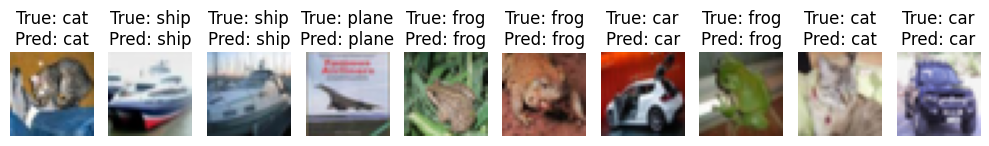

In [ ]:
# Visualize predictions on a batch from the test set
visualize_predictions(net, test_loader, num_images=10)